# Simulate excitation-preserving Qiskit circuits

ffsim supports the simulation of a restricted class of Qiskit circuits built from gates in the Qiskit circuit library. The simulation is accomplished by mapping the qubits to fermions. The circuits that can be simulated are those whose gates, except for state preparation and measurement, are "excitation-preserving," that is, they do not alter the Hamming weight of computational basis states. Concretely, the circuit should have the following structure:

1. It should begin with some X gates, which are assumed to apply to the all zeros state.
2. Next, a sequence of supported unitary gates are applied (see below).
3. Finally, measurements are only allowed to occur at the end of the circuit.

In Step 2, the following gates from the Qiskit circuit library are supported:

- CCZGate
- CPhaseGate
- CRZGate
- CSGate
- CSdgGate
- CSwapGate
- CZGate
- DiagonalGate
- GlobalPhaseGate
- IGate
- InnerProductGate
- MCPhaseGate
- PermutationGate
- PhaseGate
- PhaseOracleGate
- RZGate
- RZZGate
- SGate
- SdgGate
- SwapGate
- TGate
- TdgGate
- UCRZGate
- XXPlusYYGate
- ZGate
- iSwapGate

Currently, simulations are limited to 63 qubits (or 126 qubits for circuits with "spin Z symmetry," see [below](#circuits-with-spin-z-symmetry)).

The following code cell constructs an example of a 63-qubit circuit that would be difficult for a generic quantum circuit simulator, but is easy for ffsim because it only contains 2 excitations.

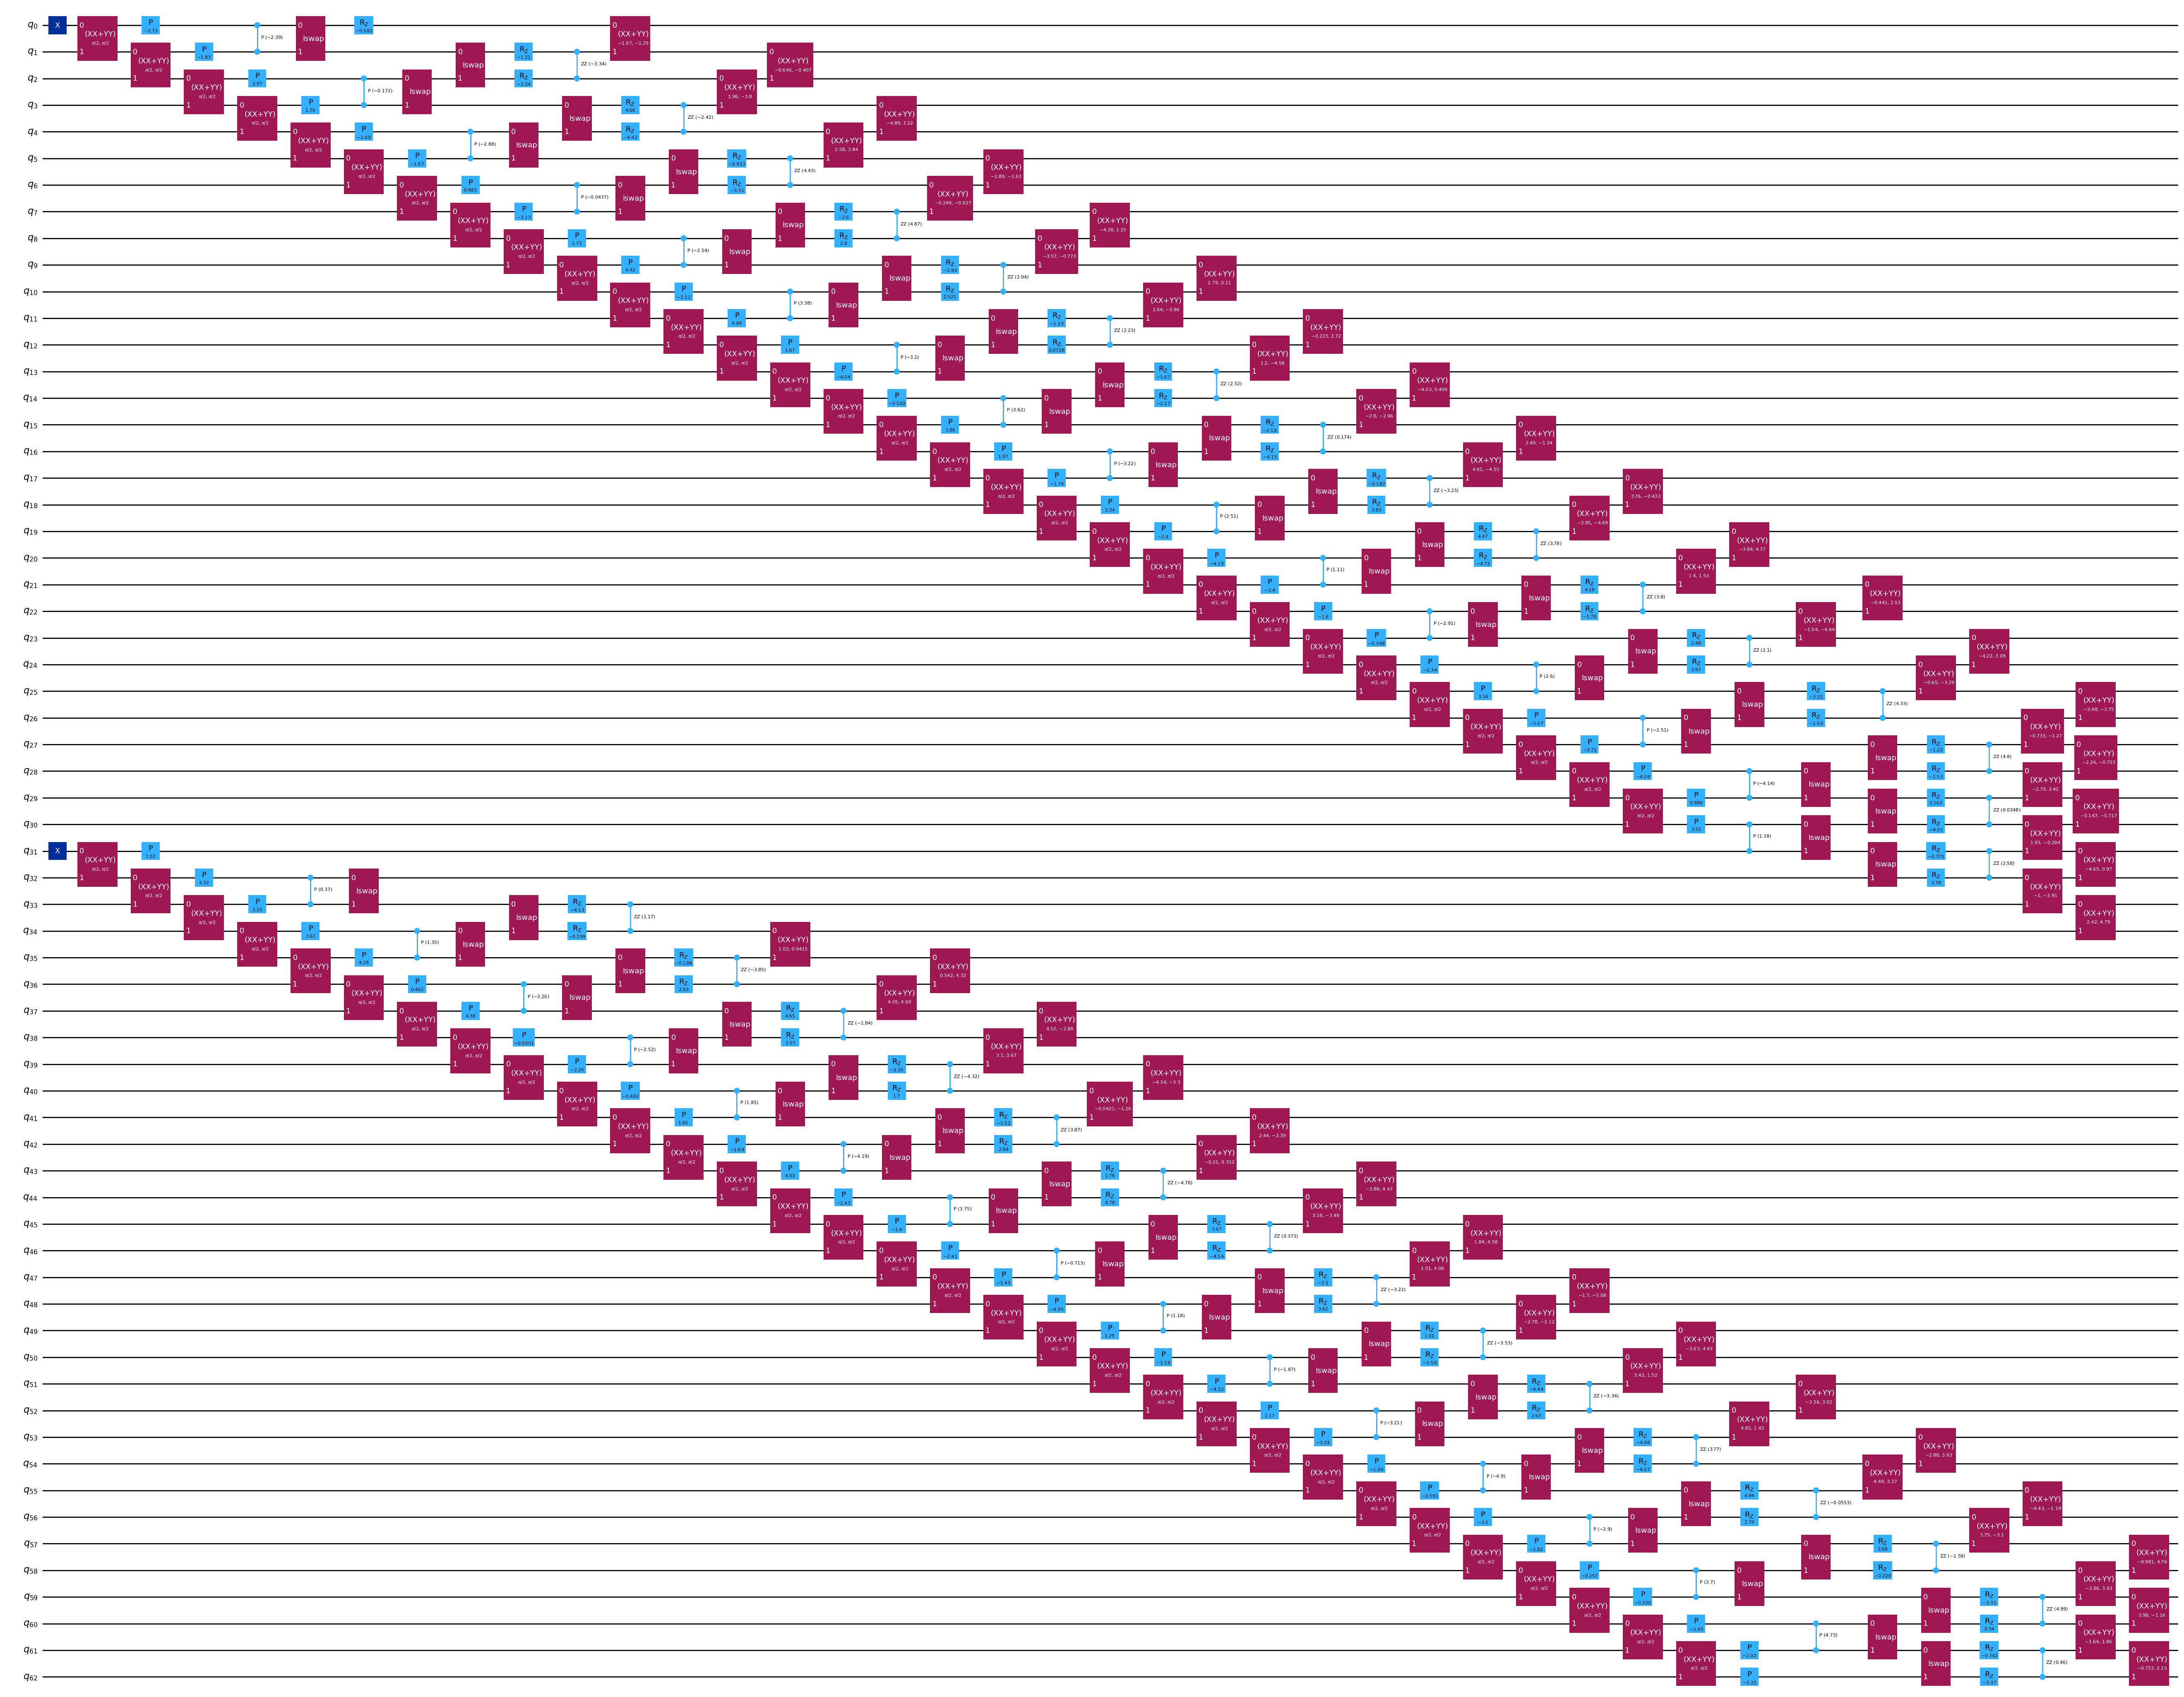

In [1]:
import numpy as np
from qiskit.circuit import QuantumCircuit, QuantumRegister
from qiskit.circuit.library import (
    CPhaseGate,
    PhaseGate,
    RZGate,
    RZZGate,
    XGate,
    XXPlusYYGate,
    iSwapGate,
)

n_qubits = 63

rng = np.random.default_rng(12345)

# Construct circuit
qubits = QuantumRegister(n_qubits, name="q")
circuit = QuantumCircuit(qubits)

circuit.append(XGate(), [qubits[0]])
circuit.append(XGate(), [qubits[n_qubits // 2]])
for i in range(n_qubits // 2 - 1):
    circuit.append(XXPlusYYGate(0.5 * np.pi, 0.5 * np.pi), qubits[i : i + 2])
for i in range(n_qubits // 2, n_qubits - 1):
    circuit.append(XXPlusYYGate(0.5 * np.pi, 0.5 * np.pi), qubits[i : i + 2])
for q in qubits:
    circuit.append(PhaseGate(rng.uniform(-5, 5)), [q])
for i in range(0, n_qubits - 1, 2):
    circuit.append(CPhaseGate(rng.uniform(-5, 5)), qubits[i : i + 2])
for i in range(0, n_qubits - 1, 2):
    circuit.append(iSwapGate(), qubits[i : i + 2])
for i in range(1, n_qubits - 1, 2):
    circuit.append(iSwapGate(), qubits[i : i + 2])
for q in qubits:
    circuit.append(RZGate(rng.uniform(-5, 5)), [q])
for i in range(1, n_qubits - 1, 2):
    circuit.append(RZZGate(rng.uniform(-5, 5)), qubits[i : i + 2])
for i in range(0, n_qubits - 1, 2):
    circuit.append(XXPlusYYGate(*rng.uniform(-5, 5, size=2)), qubits[i : i + 2])
for i in range(1, n_qubits - 1, 2):
    circuit.append(XXPlusYYGate(*rng.uniform(-5, 5, size=2)), qubits[i : i + 2])
circuit.measure_all()

# Remove final measurements before drawing circuit
circuit.remove_final_measurements(inplace=False).draw("mpl", fold=-1)

There are two ways to simulate Qiskit circuits with ffsim:

- Use ffsim's implementation of Qiskit [primitives](https://docs.quantum.ibm.com/guides/primitives). Currently, only the Sampler primitive is implemented.
- Directly use ffsim functions to compute the state vector, sample from it, and compute expectation values.

## Simulation with ffsim's Qiskit Sampler primitive

The following code cell shows how to use [FfsimSampler](../api/ffsim.qiskit.rst#ffsim.qiskit.FfsimSampler), ffsim's implementation of the Qiskit Sampler primitive, to sample from the previously constructed Qiskit circuit.

In [2]:
import ffsim

# Initialize ffsim Sampler
sampler = ffsim.qiskit.FfsimSampler(seed=rng)

# Form PUB, submit job, retrieve job result, and extract first (and only) PUB result
pub = (circuit,)
job = sampler.run([pub], shots=10_000)
result = job.result()
pub_result = result[0]

# Get counts
counts = pub_result.data.meas.get_counts()

# Display the 10 most commonly seen bitstrings and their counts
{k: v for k, v in sorted(counts.items(), key=lambda x: x[1], reverse=True)[:10]}

{'000000000000000000000000000000000001000000000000000000000000100': 1198,
 '000000000000000000000000000000000001000000000000000000000001000': 823,
 '000000000000000000000000000000000001000000000000000000000010000': 638,
 '000000000000000000000000000000000001000000000000000000000000010': 478,
 '000000000000000000000000000001000000000000000000000000000000100': 474,
 '000000000000000000000000000001000000000000000000000000000001000': 336,
 '000000000000000000000000000000000001000000000000000000001000000': 331,
 '000000000000000000000000000001000000000000000000000000000010000': 313,
 '000000000000000000000000000000000010000000000000000000000000100': 283,
 '000000000000000000000000000000001000000000000000000000000000100': 280}

## Simulation with ffsim functions

This section shows how to directly use ffsim functions to simulate the Qiskit circuit. When using these functions, the circuit should *not* contain any measurements. The following code cell removes these measurements from the circuit in place.

In [3]:
# Remove measurements from the circuit in place
circuit.remove_final_measurements()

### Compute the final state vector of the circuit

Use the `ffsim.qiskit.final_state_vector` function to compute the final state vector of the circuit. This function returns an instance of [ffsim.StateVector](../api/ffsim.rst#ffsim.StateVector), which is a dataclass with three attributes:
- `vec`: The Numpy array storing the amplitudes of the state vector.
- `norb`: The number of orbitals used to define the state space of the state vector.
- `nelec`: The number(s) of electrons used to define the state space of the state vector.

In [4]:
# Get the final state vector of the circuit
state_vec = ffsim.qiskit.final_state_vector(circuit)

print(f"State vector shape: {state_vec.vec.shape}")
print(f"Number of orbitals: {state_vec.norb}")
print(f"Number of electrons: {state_vec.nelec}")

State vector shape: (1953,)
Number of orbitals: 63
Number of electrons: 2


### Sample bitstrings

Use the `ffsim.sample_state_vector` function to sample bitstrings from a state vector.

In [5]:
from collections import Counter

counts = Counter(ffsim.sample_state_vector(state_vec, shots=10_000, seed=rng))

# Display the 10 most commonly seen bitstrings and their counts
{k: v for k, v in sorted(counts.items(), key=lambda x: x[1], reverse=True)[:10]}

{'000000000000000000000000000000000001000000000000000000000000100': 1263,
 '000000000000000000000000000000000001000000000000000000000001000': 757,
 '000000000000000000000000000000000001000000000000000000000010000': 608,
 '000000000000000000000000000001000000000000000000000000000000100': 523,
 '000000000000000000000000000000000001000000000000000000000000010': 487,
 '000000000000000000000000000000000010000000000000000000000000100': 316,
 '000000000000000000000000000001000000000000000000000000000001000': 315,
 '000000000000000000000000000010000000000000000000000000000000100': 296,
 '000000000000000000000000000000000001000000000000000000001000000': 296,
 '000000000000000000000000000001000000000000000000000000000010000': 270}

## Circuits with spin Z symmetry

In addition to being excitation-preserving, circuits with so-called spin Z symmetry have an even number of qubits, and excitations do not pass between the first half of the qubits and the second half. Such circuits arise naturally in many fermionic systems, where the first half of the qubits represent spin-up orbitals and the second half of the qubits represent spin-down orbitals. For example, the spinful variants of the [local unitary cluster Jastrow (LUCJ) ansatz](../explanations/lucj.ipynb) have this symmetry.

The following code cell constructs a 126-qubit LUCJ circuit with 2 electrons in each spin sector. While the number of qubits in this circuit is well beyond the capabilities of a generic state vector simulator, ffsim can easily simulate it by taking advantage of both the particle number conservation and spin Z symmetries.

In [6]:
# Number of spatial orbitals
norb = 63
# Numbers of alpha (spin-up) and beta (spin-down) electrons
nelec = (2, 2)

# Construct a random UCJ operator
ucj_op = ffsim.random.random_ucj_op_spin_balanced(norb=norb, seed=rng)

# Construct circuit
qubits = QuantumRegister(2 * norb, name="q")
circuit = QuantumCircuit(qubits)

circuit.append(ffsim.qiskit.PrepareHartreeFockJW(norb, nelec), qubits)
circuit.append(ffsim.qiskit.UCJOpSpinBalancedJW(ucj_op), qubits)
circuit.measure_all()

When simulating circuits with spin Z symmetry, inform `FfsimSampler` about this symmetry by passing the `norb` and `nelec` arguments during initialization. If you don't pass these arguments, then `FfsimSampler` will use only the particle number conservation symmetry, resulting in a less efficient simulation.

In [7]:
import ffsim

# Initialize ffsim Sampler
sampler = ffsim.qiskit.FfsimSampler(seed=rng, norb=norb, nelec=nelec)

# Form PUB, submit job, retrieve job result, and extract first (and only) PUB result
pub = (circuit,)
job = sampler.run([pub], shots=10_000)
result = job.result()
pub_result = result[0]

# Get counts
counts = pub_result.data.meas.get_counts()

# Display the 10 most commonly seen bitstrings and their counts
{k: v for k, v in sorted(counts.items(), key=lambda x: x[1], reverse=True)[:10]}

{'000100000000000000000000000000000000000000000000100000000000000000000000000000100000000000000100000000000000000000000000000000': 2,
 '001000000000000010000000000000000000000000000000000000000000000000000000000000010000000000000000000000000000000000000000001000': 2,
 '000000000000000000000000000000000000010000000000000010000000000000000010000000000000000000000010000000000000000000000000000000': 2,
 '000000000000000000010000000000000000000000000000000000010000000000000001001000000000000000000000000000000000000000000000000000': 2,
 '000000000000000000000001000000000000000000000100000000000000000000000000000000000100000000000000000001000000000000000000000000': 2,
 '000100000000000000000000000000000000000000000000100000000000000000010000000000000000000000000000001000000000000000000000000000': 2,
 '000000000000000000000010000010000000000000000000000000000000000000000000000000000000000000000000000000000000000000010001000000': 2,
 '000000000000000000000000001001000000000000000000000000000000